In [2]:
import typhon_model
# from architecture_loader import ArchitectureLoader
import torch.nn as nn
import torch
import numpy as np
import cv2
from matplotlib import pyplot as plt
import os
import random
from PIL import Image

In [98]:
# Pass input DemonAttack to this (which it has never seen) (remove mode)
# MODEL_PATH = './results_atari_140/20230108_like_1_but_with_bootstrap_0/models/train_model_p.pth'     # AE6 s2
# Even better (DemonAttack, Phoenix and Seaquest)
# MODEL_PATH = './results_atari_140/20230115_like_1_but_compact_fe_bigger_larger_center_bce_10envs_1/models/train_model_p.pth' 
# Qbert learns exact location!
MODEL_PATH = './results_atari_140/20230116_topk_d_7/models/train_model_p.pth' 


# MODEL_PATH = './results_atari/20230119_topk10_5envs_f_1/models/train_model_p.pth' 
# MODEL_PATH = './results_atari_140/20230108_AE8e_0_1/models/train_model_p.pth' 

IS_VAE = False
REMOVE_MODE = False # Remove the image mode from input

REMOVE_MODE_OUTPUT = False # Remove image mode from output only, to see changes

In [108]:
envs = ['DemonAttack-v5', 'FishingDerby-v5', 'Frostbite-v5', 'Kangaroo-v5', 'NameThisGame-v5', 'Phoenix-v5', 'Qbert-v5', 'Seaquest-v5', 'SpaceInvaders-v5', 'TimePilot-v5'],
ENV_NAME = 'Seaquest-v5'

INPUT_FOLDER = f'/home/jonas/Desktop/SmallDataAtari/{ENV_NAME}/val/'
INPUT_FOLDER = f'/home/jonas/Documents/master_thesis/codes/AtariTyphon/results/20230530_generate_all_8/dsets/{ENV_NAME}/0/val/'

FILENAME = random.choice(os.listdir(INPUT_FOLDER)) # Choose random file
INPUT_PATH = INPUT_FOLDER + FILENAME
print(INPUT_PATH)

/home/jonas/Documents/master_thesis/codes/AtariTyphon/results/20230530_generate_all_8/dsets/Seaquest-v5/0/val/10.png


In [109]:
def load_png(path):
#     ary = np.load(path)
    ary = Image.open(path)
    ary = np.array(ary)
    # Move color channel in front
    ary = ary.transpose(2, 0, 1)
    # print(ary.shape)
    # Normalize
    ary = np.divide(ary, 255)
    ary.shape = (1, *ary.shape)
    # Convert to tenso
    img = torch.from_numpy(ary).float()
    return img


def load_npy(path):
    ary = np.load(path)
    # Move color channel in front
    ary = ary.transpose(2, 0, 1)
    # print(ary.shape)
    # Normalize
    ary = np.divide(ary, 255)
    ary.shape = (1, *ary.shape)
    # Convert to tenso
    img = torch.from_numpy(ary).float()
    return img

def plottable_image(tensor):
    # .npy where created with cv2, meaning it uses BGR. Plt plots using RGB. Exchange them
    #   using [...,::-1]
    return (tensor[0].cpu().detach().numpy().transpose(1, 2, 0) * 255)[...,::-1].astype('uint8')

In [110]:
def get_dset_mode(folder_path, nb_samples=10):
        from scipy import stats as st
        imgs = []
        for image_path in os.listdir(folder_path)[:nb_samples]:
            tensor = load_npy(folder_path + '/' + image_path)
            img = tensor.numpy()[0]
            imgs.append(img)
        # Compute and return the mode image
#         start = time.time()
        mode_img, _position = st.mode(imgs, axis=0, keepdims=False)
#         stop = time.time()
        assert mode_img.shape == (3, 210, 160), f'Got {mode_img.shape}'
#         print(f'Mode image created (in {round(stop - start, 4)}s)')
        assert mode_img.max() <= 1
        return mode_img

In [111]:
# inp = load_npy(INPUT_PATH)
inp = load_png(INPUT_PATH)
if REMOVE_MODE:
    # Compute mode image
    mode = get_dset_mode(INPUT_FOLDER, 100)
    # Remove from input
    inp -= mode
    # Take absolute value, to avoid negative values
    inp = torch.abs(inp)

In [112]:
# Load model
model_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model = typhon_model.TyphonModel.from_state_dict(model_dict)

In [113]:
# list(model.modules())[0].fe

In [114]:
# dir(model)
# w = list(list(model.modules())[0].fe[0].parameters())[0][0][0]
# w > 1e-1

In [115]:
def compute_losses(model, input_tensor, env, mu_var):
    if mu_var:
        output, mu, logvar = model.forward(input_tensor, env)
        kld = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())).detach().numpy().item()
    else:
        output = model.forward(input_tensor, env)
        kld = 0
    mse = torch.nn.MSELoss()(output, input_tensor).detach().numpy().item()
    bce = torch.nn.BCELoss()(output, input_tensor).detach().numpy().item()
    return mse, bce, kld

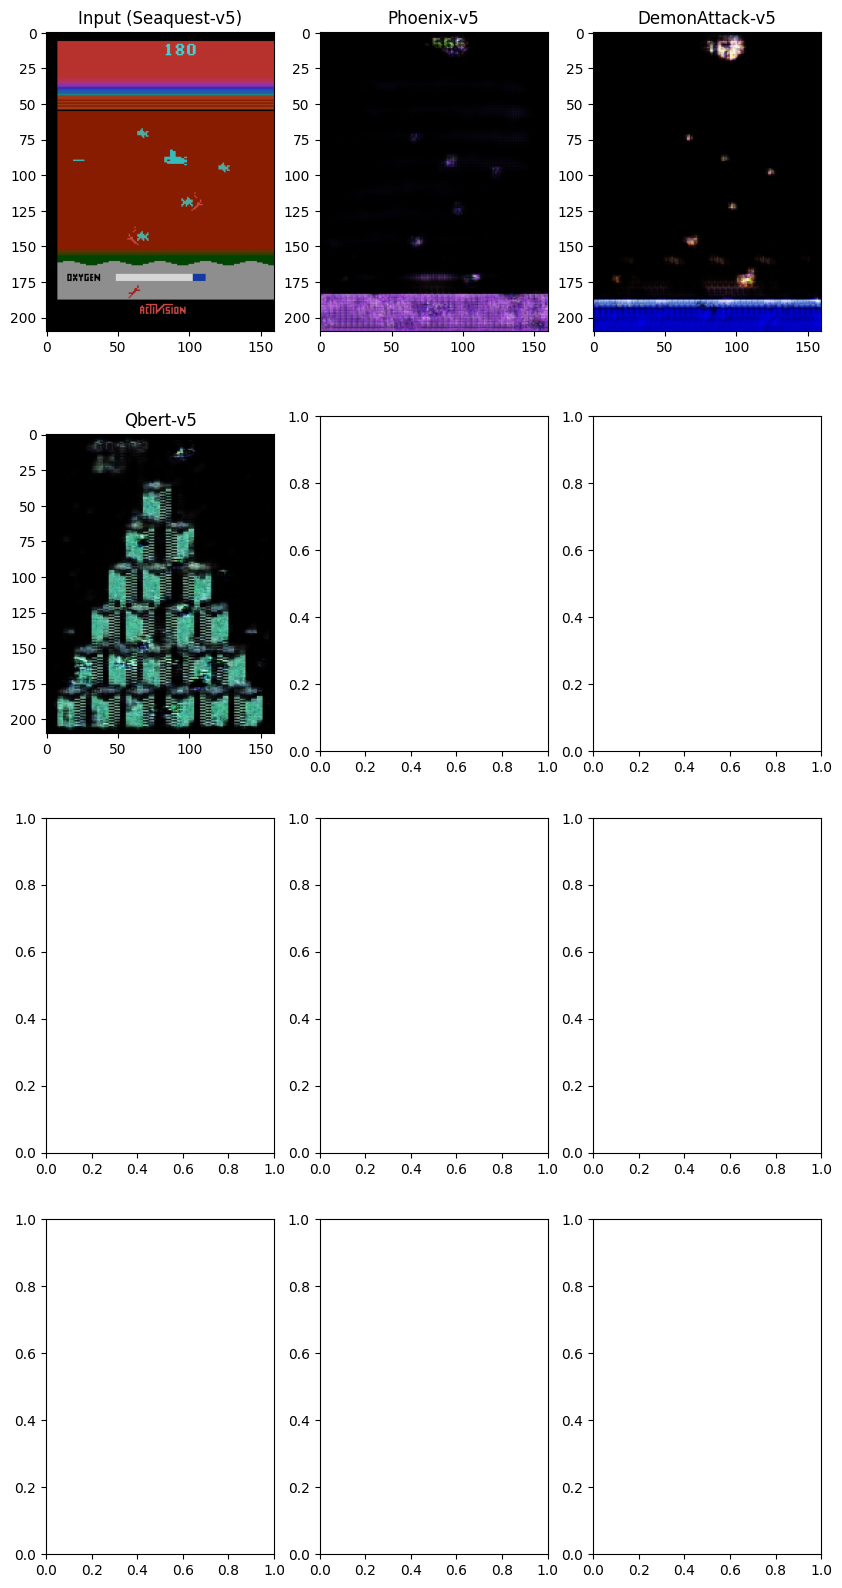

In [116]:
fig, axs = plt.subplots(4,3, figsize=(10, 20)) 

axs[0,0].imshow(plottable_image(inp))
axs[0,0].set_title(f'Input ({ENV_NAME})')

# new_inp = torch.from_numpy(np.random.random(inp.shape)).float()
# new_inp = torch.from_numpy(np.zeros(inp.shape)).float()

for env_name, ax in zip(model.dsets_names, axs.flatten()[1:]):
    folder_path = INPUT_PATH.replace(ENV_NAME, env_name).split('/')[:-1]
    folder_path = '/'.join(folder_path)
    
    out_t = model.forward(inp, env_name)[0]
    
    if IS_VAE: out_t = out_t[0]
        
    out = out_t.detach().numpy()
    
    if REMOVE_MODE_OUTPUT: 
        mode_img = get_dset_mode(folder_path, 100)
        out = np.abs(out - mode_img)

    
    out = plottable_image(torch.Tensor([out]))
    
    
    
    ax.imshow(out)
    ax.set_title(env_name)
    # Add losses
#     mse, bce, kld = compute_losses(model, inp, env_name, IS_VAE)
#     ax.text(2, 10, f'mse: {round(mse, 4)}', color='white', fontname='monospace')
#     ax.text(2, 20, f'bce: {round(bce, 4)}', color='white', fontname='monospace')
#     ax.text(2, 30, f'kld: {round(kld, 4)}', color='white', fontname='monospace')
    # Highlight 'correct' dms
    if env_name == ENV_NAME:
        ax.tick_params(color='red', labelcolor='red')
        for spine in ax.spines.values():
            spine.set_edgecolor('red')
            spine.set_linewidth(5)